In [83]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import plio
from plio.io import io_gdal
import numpy as np
from autocnet import utils
from autocnet.cg import cg as ag
import pandas
import ogr
from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph import edge
from autocnet.graph import node
from unittest.mock import Mock
from unittest.mock import MagicMock
from unittest.mock import PropertyMock
from autocnet.matcher.feature import FlannMatcher
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.path as mpath
import matplotlib.patches as mpatch

from IPython.display import display

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/adampaquette/anaconda/envs/autocnet2/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [84]:
def scale_poly(point, centroid, scalar):
    point = np.asarray(point)
    centroid = centroid[:2]
    vector = ((point - centroid)*scalar) + centroid
    return (vector)

In [85]:
def compute_vor_weight(vor, voronoi_df, poly_array, intersection_poly, node, verbose):
    i = 0
    for region in vor.regions:
        region_point = vor.points[np.argwhere(vor.point_region==i)]
        if not -1 in region:
            polygon_points = [vor.vertices[i] for i in region]
            if len(polygon_points) != 0:
                polygon = utils.utils.array_to_poly(polygon_points)
                intersection = polygon.Intersection(intersection_poly)
                poly_array = np.append(poly_array, intersection)
                polygon_area = intersection.GetArea()
                voronoi_df.loc[(voronoi_df[node + "_x"] == region_point[0][0][0]) & (voronoi_df[node + "_y"] == region_point[0][0][1]), node + '_weights'] = polygon_area
        i+=1
        
    if (verbose):
        polygons = poly_array
        for i in polygons:
            geom = i.GetGeometryRef(0)
            points = geom.GetPoints()
            plt.fill(*zip(*points), alpha = .6)
    
    

In [86]:
def voronoi(edge, clean_keys=[], k = 30, source_verbose = False, destination_verbose = False):
    source_footprint_poly = edge.source.geodata.footprint
    destination_footprint_poly = edge.destination.geodata.footprint
    intersection_poly = destination_footprint_poly.Intersection(source_footprint_poly)
    matches, mask = edge.clean(clean_keys=clean_keys)
    
    source_indices = pandas.Index(matches['source_idx'].values)
    destination_indices = pandas.Index(matches['destination_idx'].values)
    
    intersection_geom = intersection_poly.GetGeometryRef(0)
    intersect_points = intersection_geom.GetPoints()

    source_pixel_intersect_points = [edge.source.geodata.latlon_to_pixel(lat, lon) for lat, lon in intersect_points]
    dest_pixel_intersect_points = [edge.destination.geodata.latlon_to_pixel(lat, lon) for lat, lon in intersect_points]

    source_keypointsPd = edge.source.get_keypoint_coordinates(index=source_indices)
    destination_keypointsPd = edge.destination.get_keypoint_coordinates(index=destination_indices)
    
    source_convex_coords = edge.source.geodata.xy_corners
    destination_convex_coords = edge.destination.geodata.xy_corners
    
    voronoi_df = pandas.DataFrame(source_keypointsPd, columns = ["source_x", "source_y", "source_weights", 
                                                                 "destination_x", "destination_y", 
                                                                 "destination_weights"])
    voronoi_df["source_x"] = source_keypointsPd["x"]
    voronoi_df["source_y"] = source_keypointsPd["y"]
    voronoi_df["destination_x"] = destination_keypointsPd["x"]
    voronoi_df["destination_y"] = destination_keypointsPd["y"]

    source_keypoints = np.asarray(source_keypointsPd)
    destination_keypoints = np.asarray(destination_keypointsPd)
    centroid = intersection_poly.Centroid().GetPoint()
    
    for i, j in source_pixel_intersect_points:
        new_point = scale_poly((i, j), centroid, k)
        point = np.array([new_point])
        source_keypoints = np.append(source_keypoints, point, axis=0)
        
    for i, j in dest_pixel_intersect_points:
        new_point = scale_poly((i, j), centroid, k)
        point = np.array([new_point])
        destination_keypoints = np.append(destination_keypoints, point, axis=0)
    
    source_vor_polygons = []
    destination_vor_polygons = []
    source_vor = Voronoi(source_keypoints, incremental = True)
    destination_vor = Voronoi(destination_keypoints, incremental = True)
    
    compute_vor_weight(source_vor, voronoi_df, source_vor_polygons, intersection_poly, 'source', source_verbose)
    compute_vor_weight(destination_vor, voronoi_df, destination_vor_polygons, intersection_poly, 'destination', destination_verbose)
    
    return source_vor, destination_vor, voronoi_df

In [87]:
adjacency = get_path('two_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)
keypoint_df = pandas.DataFrame({'x': (15, 18, 18, 12, 12), 'y': (5, 10, 15, 15, 10)})
keypoint_matches = [[0, 0, 1, 0],
                    [0, 1, 1, 1],
                    [0, 2, 1, 2],
                    [0, 3, 1, 3],
                    [0, 4, 1, 4]]

matches_df = pandas.DataFrame(data = keypoint_matches, columns = ['source_image', 'source_idx', 
                                                                  'destination_image', 'destination_idx'])
e = edge.Edge()

e.clean = MagicMock(return_value=(matches_df, None))

source_node = MagicMock(spec = node.Node())
destination_node = MagicMock(spec = node.Node())

source_node.get_keypoint_coordinates = MagicMock(return_value=keypoint_df)
destination_node.get_keypoint_coordinates = MagicMock(return_value=keypoint_df)

e.source = source_node
e.destination = destination_node

source_geodata = Mock(spec = io_gdal.GeoDataset)
destination_geodata = Mock(spec = io_gdal.GeoDataset)

e.source.geodata = source_geodata
e.destination.geodata = destination_geodata

source_corners = [(0, 0),
                  (20, 0),
                  (20, 20),
                  (0, 20)]

destination_corners = [(10, 5),
                       (30, 5),
                       (30, 25),
                       (10, 25)]

source_xy_extent = [(0, 20), (0, 20)]

destination_xy_extent = [(10, 30), (5, 25)]

source_poly = utils.utils.array_to_poly(source_corners)
destination_poly = utils.utils.array_to_poly(destination_corners)

vals = {(10, 5):(10, 5), (20, 5):(20, 5), (20, 20):(20, 20), (10, 20):(10, 20)}

def latlon_to_pixel(i, j):
    return vals[(i, j)]

e.source.geodata.latlon_to_pixel = MagicMock(side_effect = latlon_to_pixel)
e.destination.geodata.latlon_to_pixel = MagicMock(side_effect = latlon_to_pixel)

e.source.geodata.footprint = source_poly
e.source.geodata.xy_corners = source_corners
e.source.geodata.xy_extent = source_xy_extent
e.destination.geodata.footprint = destination_poly
e.destination.geodata.xy_corners = destination_corners
e.destination.geodata.xy_extent = destination_xy_extent

[(0, 20), (0, 20)]


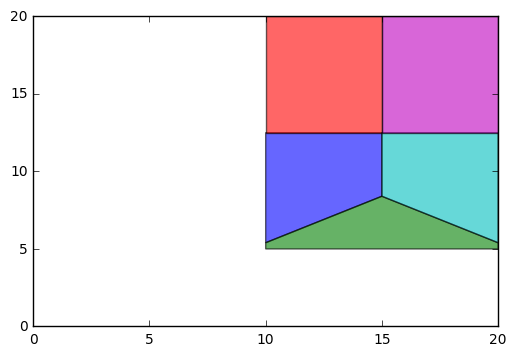

In [88]:
vor = voronoi(e, clean_keys=[], source_verbose = True, destination_verbose = False, k = 3)
source_extent = e.source.geodata.xy_extent
plt.xlim(source_extent[0][0], source_extent[0][1])
plt.ylim(source_extent[1][0], source_extent[1][1])
#voronoi_plot_2d(vor[0])
plt.show()

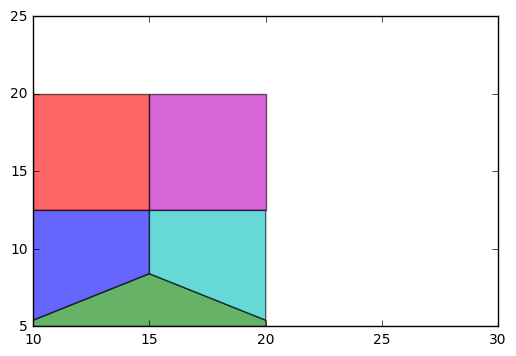

In [89]:
vor = voronoi(e, clean_keys=[], source_verbose = False, destination_verbose = True, k = 3)
destination_extent = e.destination.geodata.xy_extent
plt.xlim(destination_extent[0][0], destination_extent[0][1])
plt.ylim(destination_extent[1][0], destination_extent[1][1])
#voronoi_plot_2d(vor[0])
plt.show()

In [82]:
#Point to the adjacency Graph
adjacency = get_path('cube_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':500})

#Match
cg.match_features()

#Apply outlier detection
cg.apply_func_to_edges(edge.Edge.symmetry_check)
cg.apply_func_to_edges(edge.Edge.ratio_check)
m = cg.edge[0][1].masks
cg.minimum_spanning_tree()

#Compute a homography and apply RANSAC
cg.apply_func_to_edges("compute_fundamental_matrix", clean_keys=['ratio', 'symmetry'])
print(cg.edge[0][1].source.geodata.xy_extent)
print(cg.edge[0][1].source.geodata.latlon_extent)
#edge_source_vor = voronoi(cg.edge[0][1], "source", verbose = True)

[(0, 0), (500, 500)]


AttributeError: 'GeoDataset' object has no attribute '_latlon_extent'